# Подготовка среды

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/Shared drives/hse_BERT/hse_Af_Tr_BERT')

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 5.4MB/s 
     |████████████████████████████████| 890kB 34.2MB/s 
     |████████████████████████████████| 2.9MB 34.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=cb052704be9c61be4b51950a9d4ccb8570b766f93964cb0110b6899c98d63e9c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
!pip install razdel

In [5]:
import torch
import nltk
import re
import json
import time
import numpy as np
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

from scipy.spatial.distance import cosine

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [6]:
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [7]:
import pickle as pc

def my_dump(file, name):
    with open("./bin/" + name + ".pic", 'wb') as f:
        pc.dump(file, f)

def my_load(name):
    with open("./bin/" + name + ".pic", 'rb') as f:
        return pc.load(f)

In [8]:
from razdel import sentenize

# short 

## generate (split) sentences

In [ ]:
with open("./texts/all_cyberleninka_liter2/all_cyberleninka_liter2.txt", 'r') as f:
    data = f.read()

In [ ]:
%%time
sent1 = list(sentenize(data))

CPU times: user 5min 54s, sys: 2.37 s, total: 5min 56s
Wall time: 5min 57s


In [ ]:
%%time
my_dump(sent1, "sent1")
# my_dump(sent2, "sent2")

CPU times: user 20.2 s, sys: 2.33 s, total: 22.5 s
Wall time: 33 s


## read sentences

In [10]:
%%time
sent1 = my_load("sent1")

CPU times: user 21.6 s, sys: 6.31 s, total: 27.9 s
Wall time: 36.4 s


In [11]:
def get_text_from_ST(ss):
    return ss.text

In [12]:
sent = list(map(get_text_from_ST, sent1))

In [13]:
len(sent)

6287032

## work

In [26]:
for_embeddings = {
    "король", 
    "королева",
    "мужчина",
    "женьщина"
}

In [42]:
text = "консультация — это старинное название всей художественной литературы, король, королева, королю, королям, королем, королями"


In [43]:
a, b = get_embeddings(text)
a

['[CLS]',
 'консульта',
 '##ция',
 '—',
 'это',
 'старинное',
 'название',
 'всей',
 'художественной',
 'литературы',
 ',',
 'король',
 ',',
 'королева',
 ',',
 'королю',
 ',',
 'короля',
 '##м',
 ',',
 'королем',
 ',',
 'королями',
 '[SEP]']

In [11]:
def sum_tensors(token):
    return torch.sum(token[-4:], dim=0)

def get_embeddings(text):
    tokenized_text = tokenizer.tokenize("[CLS] " + text.lower() + " [SEP]")
    if len(tokenized_text) > 80:
        return [],[]
    marked_text = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([marked_text])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.squeeze(torch.stack(hidden_states, dim=0),
                                    dim=1).permute(1,0,2)
    
    token_vecs_sum = list(map(sum_tensors, token_embeddings))
    return tokenized_text, token_vecs_sum

# token_vecs = hidden_states[-2][0]
# sentence_embedding = torch.mean(token_vecs, dim=0)

In [17]:
# pr_tr = dict.fromkeys(for_embeddings)
# for i in pr_tr:
#     pr_tr[i] = []

# pr_tr

In [18]:
# words = re.compile('\w+')
# words.fullmatch("khbkjhk")
# re.fullmatch(r'\w+', "12kb12lkjnl")

In [19]:
# %%time
# for j in range(1):
#     for i in range(j * 100, (j + 1) * 100):
#         tt, tvs = get_embeddings(sent[i])
#         for i in range(len(tt)):
#             if tt[i].isalpha():
#                 if tt[i] in pr_tr:
#                     pr_tr[tt[i]].append(tvs[i])
#                 else:
#                     pr_tr[tt[i]] = [tvs[i]]

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

In [20]:
%%time
batch = 10000
start_time = time.time()
for j in range(95, 100):
    pr_tr = {}
    temp_time = time.time()
    for i in range(j * batch, (j + 1) * batch):
        tt, tvs = get_embeddings(sent[i])
        for i in range(len(tt)):
            if tt[i].isalpha()  and len(tt[i]) > 2:
                if tt[i] in pr_tr:
                    pr_tr[tt[i]].append(tvs[i])
                else:
                    pr_tr[tt[i]] = [tvs[i]]

    with open("./embeddings/sent1/bin/{}_{:05d}.pic".format(batch, j), 'wb') as f:
        pc.dump(pr_tr, f)

    # with open("./embeddings/sent1/json/{:05d}.pic".format(i), 'w') as f:
    #     json.dump(pr_tr, f)

    t = time.time()
    print("done {:05d} --- time: {}\t--- total: {}".format(j, t - temp_time, t - start_time))

# for i in pr_tr:
#     print(i, len(pr_tr[i]))

done 00095 --- time: 2109.1874635219574	--- total: 2109.187467098236
done 00096 --- time: 1610.196703672409	--- total: 3719.5902433395386
done 00097 --- time: 1447.865315437317	--- total: 5167.999427556992
done 00098 --- time: 1521.1164331436157	--- total: 6689.356902599335
done 00099 --- time: 1301.5135962963104	--- total: 7991.188751220703
CPU times: user 2h 9min 29s, sys: 45.6 s, total: 2h 10min 15s
Wall time: 2h 13min 11s


In [ ]:
out = list(zip(pr_tr.keys(), list(map(len, pr_tr.values()))))
out.sort(key = lambda i: i[1], reverse=True)
out

In [ ]:
np.array(pr_tr)

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)


In [ ]:

diff_bank = 1 - cosine(token_vecs_sum[11], token_vecs_sum[12])
print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.74


In [ ]:
?sent1[0]

## oldwork

In [ ]:
text = 'Чтобы не грусть, что вместо сети определили на пары.'
text2 = "At eight o'clock on Thursday morning. Arthur didn't feel very good."

In [ ]:
marked_text = "[CLS] " + text.lower() + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
segments_ids = [1] * len(tokenized_text)

In [ ]:
tokenized_text

['[CLS]',
 'чтобы',
 'не',
 'груст',
 '##ь',
 ',',
 'что',
 'вместо',
 'сети',
 'определили',
 'на',
 'пары',
 '.',
 '[SEP]']

In [ ]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
# token_i = 5
# layer_i = 5
# vec = hidden_states[layer_i][batch_i][token_i]

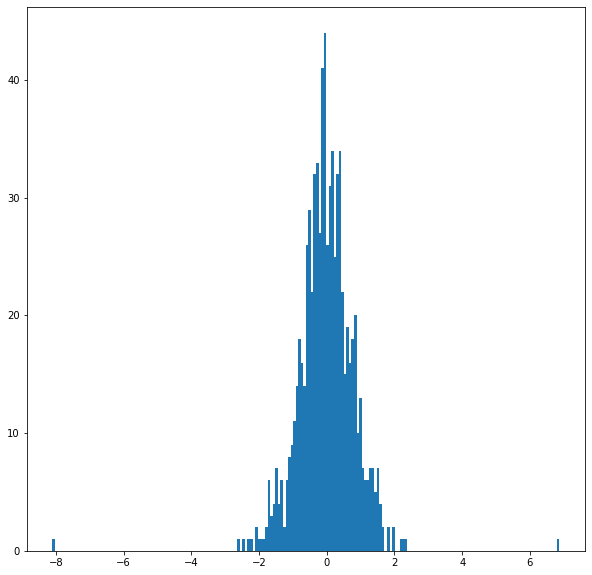

In [ ]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [ ]:
# Remove dimension 1, the "batches".
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings = torch.squeeze(token_embeddings, dim=1).permute(1,0,2)

In [ ]:
token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 17 x 768


In [ ]:
len(token_vecs_sum)

17

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 замок
2 сто
3 ##ял
4 не
5 ##пр
6 ##ист
7 ##уп
8 ##ныи
9 .
10 замок
11 легко
12 от
13 ##крыл
14 ##ся
15 .
16 [SEP]


In [ ]:
token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
token_vecs.size()

torch.Size([17, 768])

In [ ]:
diff_bank = 1 - cosine(token_vecs_sum[1], token_vecs_sum[10])
diff_bank1 = 1 - cosine(token_vecs[1], token_vecs[10])
# same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_bank)
# print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.92
